In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from sklearn.model_selection import train_test_split
import requests
import torch.nn as nn
import torch.optim as optim
import random
!pip install datasets

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
from nltk.tokenize import sent_tokenize, word_tokenize
from datasets import load_dataset
import nltk
nltk.download('punkt')

dataset = load_dataset('cnn_dailymail', '3.0.0', split="train[:1500]") 

train_data = dataset
val_data = load_dataset('cnn_dailymail', '3.0.0', split="validation[:500]") 
test_data = load_dataset('cnn_dailymail', '3.0.0', split="test[:500]")  

def preprocess_text(text):
    sentences = sent_tokenize(text)
    tokenized_sentences = [word_tokenize(sent) for sent in sentences]
    return tokenized_sentences

train_summaries = [example['highlights'] for example in train_data]
train_texts = [example['article'] for example in train_data]

val_summaries = [example['highlights'] for example in val_data]
val_texts = [example['article'] for example in val_data]

test_summaries = [example['highlights'] for example in test_data]
test_texts = [example['article'] for example in test_data]

/home/ubuntu/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from collections import Counter
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, sequences_input, sequences_target, max_length):
        self.sequences_input = sequences_input
        self.sequences_target = sequences_target
        self.max_length = max_length

    def __len__(self):
        return len(self.sequences_input)

    def __getitem__(self, index):
        input_sequence = self.sequences_input[index]
        target_summary = self.sequences_target[index]

        input_sequence = self.pad_sequence(input_sequence, self.max_length)
        target_summary = self.pad_sequence(target_summary, self.max_length)

        input_tensor = torch.tensor(input_sequence, dtype=torch.long)
        target_tensor = torch.tensor(target_summary, dtype=torch.long)

        return input_tensor, target_tensor

    def pad_sequence(self, sequence, max_length):
        if len(sequence) < max_length:
            sequence = sequence + [0] * (max_length - len(sequence))
        else:
            sequence = sequence[:max_length]
        return sequence

def sentence_to_sequence(sentence, vocab):
    return [vocab[word] for word in sentence if word in vocab]

import nltk
from collections import Counter

vocab_input = {}
vocab_target = {}

word_counter_input = Counter(word for text in train_texts for word in nltk.word_tokenize(text))
word_counter_target = Counter(word for summary in train_summaries for word in nltk.word_tokenize(summary))

for word, count in word_counter_input.items():
    if word not in vocab_input:
        vocab_input[word] = len(vocab_input)

for word, count in word_counter_target.items():
    if word not in vocab_target:
        vocab_target[word] = len(vocab_target)

train_sequences_input = [sentence_to_sequence(word_tokenize(text), vocab_input) for text in train_texts]
val_sequences_input = [sentence_to_sequence(word_tokenize(text), vocab_input) for text in val_texts]
test_sequences_input = [sentence_to_sequence(word_tokenize(text), vocab_input) for text in test_texts]

train_sequences_target = [sentence_to_sequence(word_tokenize(summary), vocab_target) for summary in train_summaries]
val_sequences_target = [sentence_to_sequence(word_tokenize(summary), vocab_target) for summary in val_summaries]
test_sequences_target = [sentence_to_sequence(word_tokenize(summary), vocab_target) for summary in test_summaries]

max_length = 128
max_summary_length = 100

train_dataset = CustomDataset(train_sequences_input, train_sequences_target, max_length)
val_dataset = CustomDataset(val_sequences_input, val_sequences_target, max_length)
test_dataset = CustomDataset(test_sequences_input, test_sequences_target, max_length)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

class LSTMModel(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super(LSTMModel, self).__init__()
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, batch_first=True, dropout=dropout)
        self.fc_out = nn.Linear(hid_dim, input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, (hidden, cell) = self.rnn(embedded)
        prediction = self.fc_out(outputs)
        return prediction

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder_input_dim = len(vocab_input)
decoder_output_dim = len(vocab_target)
embedding_dim = 100
hidden_dim = 256
num_layers = 2
dropout = 0.5

lstm_model = LSTMModel(encoder_input_dim, embedding_dim, hidden_dim, num_layers, dropout).to(device)

criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(lstm_model.parameters(), lr=0.01)

[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Epochs: 10

In [4]:
l1=[]
l2=[]
def train_model(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    for batch_inputs, batch_targets in dataloader:
        torch.cuda.empty_cache()
        batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)
        optimizer.zero_grad()
        outputs = model(batch_inputs)
        torch.cuda.empty_cache()
        outputs = outputs.view(-1, outputs.size(2))
        batch_targets = batch_targets.view(-1)
        loss = criterion(outputs, batch_targets)
        torch.cuda.empty_cache()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        torch.cuda.empty_cache()
    l1.append(total_loss / len(dataloader))
    return total_loss / len(dataloader)


def validate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for batch_inputs, batch_targets in dataloader:
            torch.cuda.empty_cache()
            batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)
            outputs = model(batch_inputs)
            torch.cuda.empty_cache()
            outputs = outputs.view(-1, outputs.size(2))
            batch_targets = batch_targets.view(-1)
            loss = criterion(outputs, batch_targets)
            total_loss += loss.item()
            torch.cuda.empty_cache()
    l2.append(total_loss / len(dataloader))
    return total_loss / len(dataloader)


num_epochs = 10
for epoch in range(num_epochs):
    train_loss = train_model(lstm_model, train_loader, criterion, optimizer, device)
    validation_loss = validate_model(lstm_model, val_loader, criterion, device)
    torch.cuda.empty_cache()
    print(f"Epoch [{epoch + 1}/{num_epochs}] Train Loss: {train_loss:.4f} Validation Loss: {validation_loss:.4f}")

Epoch [1/10] Train Loss: -0.1244 Validation Loss: -0.3229
Epoch [2/10] Train Loss: -0.4240 Validation Loss: -0.7135
Epoch [3/10] Train Loss: -0.7995 Validation Loss: -1.2527
Epoch [4/10] Train Loss: -1.3993 Validation Loss: -2.2825
Epoch [5/10] Train Loss: -3.0819 Validation Loss: -6.4529
Epoch [6/10] Train Loss: -13.7540 Validation Loss: -34.0452
Epoch [7/10] Train Loss: -50.2577 Validation Loss: -87.5487
Epoch [8/10] Train Loss: -97.2863 Validation Loss: -144.6071
Epoch [9/10] Train Loss: -145.7291 Validation Loss: -202.2649
Epoch [10/10] Train Loss: -194.4652 Validation Loss: -260.1542


In [5]:
def evaluate_model(model, dataloader, device):
    model.eval()
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for batch_inputs, batch_targets in dataloader:
            batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)
            outputs = model(batch_inputs)
            _, predicted = torch.max(outputs, 2)
            total_correct += (predicted == batch_targets).sum().item()
            total_samples += batch_targets.numel()

    accuracy = total_correct / total_samples
    return accuracy

accuracy = evaluate_model(lstm_model, test_loader, device)
print(f"Test Accuracy: {accuracy*100:.6f}")

Test Accuracy: 74.326563


In [6]:
def evaluate_model(model, dataloader, device):
    model.eval()
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for batch_inputs, batch_targets in dataloader:
            batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)
            outputs = model(batch_inputs)
            _, predicted = torch.max(outputs, 2)
            total_correct += (predicted == batch_targets).sum().item()
            total_samples += batch_targets.numel()

    accuracy = total_correct / total_samples
    return accuracy

accuracy = evaluate_model(lstm_model, val_loader, device)
print(f"Validation Accuracy: {accuracy*100:.6f}")

Validation Accuracy: 75.348438


In [7]:
def evaluate_model(model, dataloader, device):
    model.eval()
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for batch_inputs, batch_targets in dataloader:
            batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)
            outputs = model(batch_inputs)
            _, predicted = torch.max(outputs, 2)
            total_correct += (predicted == batch_targets).sum().item()
            total_samples += batch_targets.numel()

    accuracy = total_correct / total_samples
    return accuracy

accuracy = evaluate_model(lstm_model, train_loader, device)
print(f"Train Accuracy: {accuracy*100:.6f}")

Train Accuracy: 63.525000


In [8]:
import matplotlib.pyplot as plt

Text(0.5, 0.98, 'LSTM MODEL')

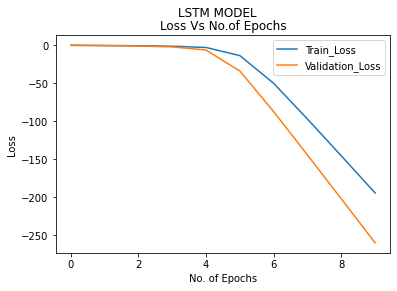

In [9]:
plt.plot(l1, label = "Train_Loss")
plt.plot(l2, label = "Validation_Loss")
plt.title("Loss Vs No.of Epochs")
plt.xlabel("No. of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.suptitle("LSTM MODEL")

Epochs: 15

In [10]:
l3=[]
l4=[]
def train_model(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    for batch_inputs, batch_targets in dataloader:
        torch.cuda.empty_cache()
        batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)
        optimizer.zero_grad()
        outputs = model(batch_inputs)
        torch.cuda.empty_cache()
        outputs = outputs.view(-1, outputs.size(2))
        batch_targets = batch_targets.view(-1)
        loss = criterion(outputs, batch_targets)
        torch.cuda.empty_cache()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        torch.cuda.empty_cache()
    l3.append(total_loss / len(dataloader))
    return total_loss / len(dataloader)


def validate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for batch_inputs, batch_targets in dataloader:
            torch.cuda.empty_cache()
            batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)
            outputs = model(batch_inputs)
            torch.cuda.empty_cache()
            outputs = outputs.view(-1, outputs.size(2))
            batch_targets = batch_targets.view(-1)
            loss = criterion(outputs, batch_targets)
            total_loss += loss.item()
            torch.cuda.empty_cache()
    l4.append(total_loss / len(dataloader))
    return total_loss / len(dataloader)


num_epochs = 15
for epoch in range(num_epochs):
    train_loss = train_model(lstm_model, train_loader, criterion, optimizer, device)
    validation_loss = validate_model(lstm_model, val_loader, criterion, device)
    torch.cuda.empty_cache()
    print(f"Epoch [{epoch + 1}/{num_epochs}] Train Loss: {train_loss:.4f} Validation Loss: {validation_loss:.4f}")

Epoch [1/15] Train Loss: -243.3302 Validation Loss: -318.1098
Epoch [2/15] Train Loss: -292.2258 Validation Loss: -376.0690
Epoch [3/15] Train Loss: -341.0895 Validation Loss: -434.0263
Epoch [4/15] Train Loss: -389.9927 Validation Loss: -491.9883
Epoch [5/15] Train Loss: -438.8653 Validation Loss: -549.9491
Epoch [6/15] Train Loss: -487.6884 Validation Loss: -607.9041
Epoch [7/15] Train Loss: -536.6826 Validation Loss: -665.8722
Epoch [8/15] Train Loss: -585.5131 Validation Loss: -723.8343
Epoch [9/15] Train Loss: -634.3398 Validation Loss: -781.7915
Epoch [10/15] Train Loss: -683.3294 Validation Loss: -839.7582
Epoch [11/15] Train Loss: -732.1809 Validation Loss: -897.7223
Epoch [12/15] Train Loss: -780.9810 Validation Loss: -955.6809
Epoch [13/15] Train Loss: -829.9968 Validation Loss: -1013.6495
Epoch [14/15] Train Loss: -878.7147 Validation Loss: -1071.6068
Epoch [15/15] Train Loss: -927.6675 Validation Loss: -1129.5688


Text(0.5, 0.98, 'LSTM MODEL')

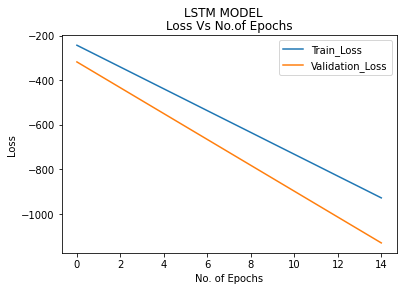

In [11]:
plt.plot(l3, label = "Train_Loss")
plt.plot(l4, label = "Validation_Loss")
plt.title("Loss Vs No.of Epochs")
plt.xlabel("No. of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.suptitle("LSTM MODEL")

Epochs: 20

In [12]:
l5=[]
l6=[]
def train_model(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    for batch_inputs, batch_targets in dataloader:
        torch.cuda.empty_cache()
        batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)
        optimizer.zero_grad()
        outputs = model(batch_inputs)
        torch.cuda.empty_cache()
        outputs = outputs.view(-1, outputs.size(2))
        batch_targets = batch_targets.view(-1)
        loss = criterion(outputs, batch_targets)
        torch.cuda.empty_cache()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        torch.cuda.empty_cache()
    l5.append(total_loss / len(dataloader))
    return total_loss / len(dataloader)


def validate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for batch_inputs, batch_targets in dataloader:
            torch.cuda.empty_cache()
            batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)
            outputs = model(batch_inputs)
            torch.cuda.empty_cache()
            outputs = outputs.view(-1, outputs.size(2))
            batch_targets = batch_targets.view(-1)
            loss = criterion(outputs, batch_targets)
            total_loss += loss.item()
            torch.cuda.empty_cache()
    l6.append(total_loss / len(dataloader))
    return total_loss / len(dataloader)


num_epochs = 20
for epoch in range(num_epochs):
    train_loss = train_model(lstm_model, train_loader, criterion, optimizer, device)
    validation_loss = validate_model(lstm_model, val_loader, criterion, device)
    torch.cuda.empty_cache()
    print(f"Epoch [{epoch + 1}/{num_epochs}] Train Loss: {train_loss:.4f} Validation Loss: {validation_loss:.4f}")

Epoch [1/20] Train Loss: -976.5257 Validation Loss: -1187.5286
Epoch [2/20] Train Loss: -1025.3077 Validation Loss: -1245.4829
Epoch [3/20] Train Loss: -1074.2803 Validation Loss: -1303.4436
Epoch [4/20] Train Loss: -1123.1975 Validation Loss: -1361.4058
Epoch [5/20] Train Loss: -1172.1450 Validation Loss: -1419.3717
Epoch [6/20] Train Loss: -1221.0835 Validation Loss: -1477.3400
Epoch [7/20] Train Loss: -1269.9125 Validation Loss: -1535.3063
Epoch [8/20] Train Loss: -1318.7400 Validation Loss: -1593.2704
Epoch [9/20] Train Loss: -1367.7685 Validation Loss: -1651.2412
Epoch [10/20] Train Loss: -1416.5443 Validation Loss: -1709.2068
Epoch [11/20] Train Loss: -1465.3767 Validation Loss: -1767.1692
Epoch [12/20] Train Loss: -1514.3118 Validation Loss: -1825.1355
Epoch [13/20] Train Loss: -1563.0617 Validation Loss: -1883.0943
Epoch [14/20] Train Loss: -1612.0031 Validation Loss: -1941.0582
Epoch [15/20] Train Loss: -1660.9684 Validation Loss: -1999.0239
Epoch [16/20] Train Loss: -1709.759

Text(0.5, 0.98, 'LSTM MODEL')

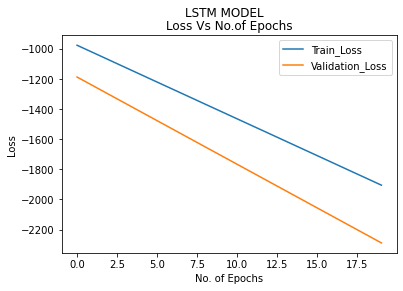

In [13]:
plt.plot(l5, label = "Train_Loss")
plt.plot(l6, label = "Validation_Loss")
plt.title("Loss Vs No.of Epochs")
plt.xlabel("No. of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.suptitle("LSTM MODEL")

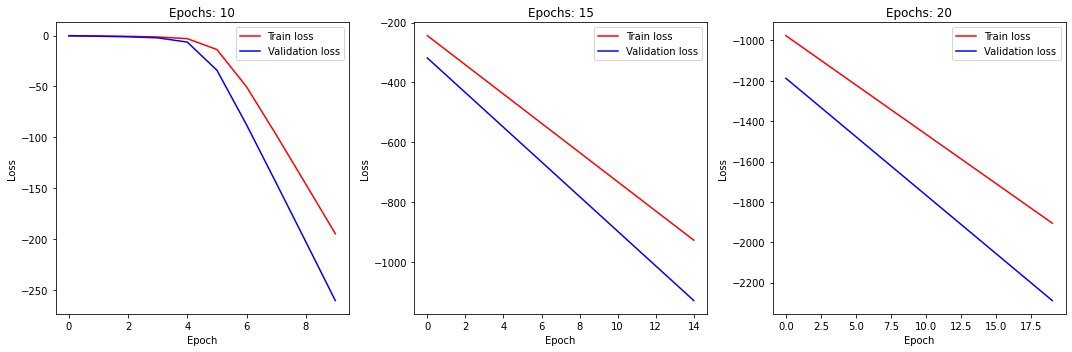

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(l1, label='Train loss', color='red')
axes[0].plot(l2, label='Validation loss', color='blue')
axes[0].set_title('Epochs: 10')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(l3, label='Train loss', color='red')
axes[1].plot(l4, label='Validation loss', color='blue')
axes[1].set_title('Epochs: 15')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

axes[2].plot(l5, label='Train loss', color='red')
axes[2].plot(l6, label='Validation loss', color='blue')
axes[2].set_title('Epochs: 20')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Loss')
axes[2].legend()

plt.tight_layout()

plt.show()